# Stock Price Forecaster 0.1b
## Machine Learning Engineer Nanodegree
**Calvin Ku**

**June 6, 2016**

## Definition

### Project Overview
This project is about building a stock price forecaster. The forecaster is generally a regressor, which tries to predict a number for a given stock for a given future date (for example, the price of GOOGL 10 days from now). The goal of this project is to build the forecaster that can predict the stock price 63 days from the day the prediction is made. We will use GOOGL as an example in this project but the same method can be applied to any stock. In the end we will evaluate our method on 10 randomly picked stocks from S&P 500 (2009). The forecaster is meant be combined with a portfolio optimizer to form a total decisioning solution for trading to give trading suggustion to investors..

#### Data used in this project
The datasets that will be used in this project include:
* Historical stock prices data
* St. Louis Fed Financial Stress Index data

For the historical data, we will ready the stocks of S&P 500 (2009) range from January 1, 2009, to June 28, 2016. Some of the stocks are not traded as of this writring so are excluded. 

### Problem Statement
Problem with trading is that you never know when is the best time to buy or sell a stock, as you never know if the stock price will go up or go down in the future. This simple forecaster is an attempt to solve this problem.

For any stock in S&P 500 (2009), the forecaster is able to predict the prices of that stock 63 days in the future. The precision of the forecast vary from stock to stock but for the forecaster to be anyway useful generally we want to limit the mean error to be around 5% of the stock price.

### Metrics
In this project we use MSE (mean sqauared error) as the metric, since our goal is to try to make the predicted price as close to real price as possible. To be more specific, the reason why MSE is good is because:

1. The overestimations (when the predicted value is higher than the actual) and underestimations (when lower than the actual) of the model don't cancel out when you take the average, therefore you won't underestimate the error.

2. The square of a very small value is even smaller and the square of a big value is even bigger. We are looking for a model that can consistently make predictions that stay close to the actual, and with MSE, we can punish really off predictions even more (for example, being off by 20 is a lot more than twice as bad as being off by 10) to get a consistent model.

3. One problem with MSE is that it is more susceptible to outliers. Fortunately, the good thing about financial data is that the data is quite pristine so we can expect not so much corrupted and misinput data. On the other hand, unlike cross-sectional data, the continuous nature of stock price data itself eliminates the possibility of any "special case" and makes spotting corrupted data rather easy.

Along with MSE I also log the $r^2$ to get an idea of the correlation between the data and our model.

## Analysis
### Data Exploration
About the data used in this project, we assume the following:

* CAPM (Capital Asset Pricing Model), where it states that any stock price on the market is a multitude of the market trend (in our case we use the stock price of SPY), plus a constant $\alpha$ which is specific to that stock. 
* Believing that economy is corrlated to the the stock market
* Believing that any price change without a good amount of volume behind is just a random fluctuation

Therefore, the raw data used in this project includes the following:

* SPY Adj Close
* SPY Volume
* Adj Close of the target stock
* Volume of the target stock
* STLFSI - St. Louis Fed Financial Stress Index data

Since SPY is always traded in the trading days, we use it to get the trading days.

#### First look
Let's first take a glance at our data and see if there's any missing values.

In [1]:
from __future__ import division

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import display

def load_data(stock_list_csv, market_csv, start_date, end_date, symbol_list=None, random_state=0, number_of_stocks=10):
    """The function does the following:
    1. Load the list of stocks
    2. Load the market data (SPY or other ETF data)
    3. Load the economy data (STLFSI or other index data)
    4. Randomly picks 10 stocks and load into a dictionary of dataframes if symbol_list is not provided,
       otherwise load the stocks in the symbo_list instead
    5. Return a dictionary of dataframes of stock data, with stock symbols as the keys
    """
    # Set up the empty main dataframe using the defined data range
    date_range = pd.date_range(start_date, end_date)
    df_main = pd.DataFrame(index=date_range)
    
    # Load SPY to get trading days
    dfSPY = pd.read_csv(market_csv, index_col='Date', parse_dates=True, usecols=['Date', 'Adj Close', 'Volume'], na_values = ['nan'])
    dfSPY = dfSPY.rename(columns={'Adj Close': 'SPY', 'Volume': 'SPY_Vol'})
    
    # Get SPY within the target date range
    df_main = df_main.join(dfSPY)
    
    # Drop NaN values
    df_main = df_main.dropna()
    
    # Load target stock list
    dfSPY500_2009 = pd.read_csv(stock_list_csv, header=None, usecols = [1])
    
    # Ready the symbol list
    if symbol_list is None:
        np.random.seed(random_state)
        symbol_list = np.random.choice(dfSPY500_2009[1].tolist(), number_of_stocks)
        
    # Load the FSI data
    dfFSI = pd.read_csv('STLFSI.csv', index_col='DATE', parse_dates=True, na_values = ['nan'])
    
    # Load target stocks
    result_dict = {}
    
    for symbol in symbol_list:
        df_temp = pd.read_csv('stock_data/' + symbol + '.csv', index_col="Date", parse_dates=True, usecols = ['Date', 'Volume', 'Adj Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Volume': symbol + '_Vol', 'Adj Close': symbol})
        df_temp2 = df_main.join(df_temp, how='left')
        df_temp2 = df_temp2.join(dfFSI, how='left')
        result_dict[symbol] = df_temp2
    
    return result_dict

symbol = 'BF-B'
stock_dict = load_data('dev.csv', 'stock_data/SPY.csv', '2009-01-01', '2016-06-30', symbol_list=['BF-B', 'GOOGL', 'YHOO', 'IBM', 'MSFT'], random_state=0, number_of_stocks=10)
df_main = stock_dict[symbol]

display(df_main.head())
print(df_main.isnull().sum())

,SPY_Vol,SPY,BF-B_Vol,BF-B,STLFSI
2009-01-02,227566300.0,79.602650,562300,30.514303,3.643
2009-01-05,240349700.0,79.508455,671200,30.600990,NaN
2009-01-06,328260900.0,80.039370,623500,29.728326,NaN
2009-01-07,280899200.0,77.641697,765600,28.485795,NaN
2009-01-08,263834400.0,77.958535,629700,28.705403,NaN


SPY_Vol        0
SPY            0
BF-B_Vol       0
BF-B           0
STLFSI      1510
dtype: int64


We can see that we don't have any missing values to be taken care of for GOOGL. The financial stress index is calculated weekly so we'll have to fill in for the dates between the calculations ourselves.

#### A closer look
Now let's take a look at the statistics of the stock price data.

In [2]:
n_days = df_main.shape[0]
min_price = df_main[symbol].min()
max_price = df_main[symbol].max()
mean_price = df_main[symbol].mean()
median_price = np.median(df_main[symbol])
std_price = df_main[symbol].std()
cv = std_price / mean_price

print("Number of traded days: {}".format(n_days))
print("Minimum stock price: {}".format(min_price))
print("Maximum stock price: {}".format(max_price))
print("Mean stock price: {}".format(mean_price))
print("Median stock price: {}".format(median_price))
print("Standard deviation of stock price: {}".format(std_price))
print("Coefficient of variation of stock price: {}".format(cv))

Number of traded days: 1885
Minimum stock price: 21.528436
Maximum stock price: 109.318471
Mean stock price: 61.5923648568
Median stock price: 60.717771
Standard deviation of stock price: 25.2869289158
Coefficient of variation of stock price: 0.410552979653


We can see that we don't have any outliers here in the stock price data. And the coefficient of variation is less than 1. However, we can see the mean and median differ by quite a lot, so usually this is a good time to apply some non-linear feature scaling.

Before we do that, let's inspect the statistics of other features.

In [3]:
display(df_main.describe())

,SPY_Vol,SPY,BF-B_Vol,BF-B,STLFSI
count,1.885000e+03,1885.000000,1.885000e+03,1885.000000,375.000000
mean,1.645517e+08,142.012669,4.976069e+05,61.592365,-0.677891
std,8.730687e+07,43.102172,3.507421e+05,25.286929,0.992101
min,3.731780e+07,58.323328,6.690000e+04,21.528436,-1.655000
25%,1.040035e+08,105.351470,3.023000e+05,38.542884,-1.300500
50%,1.437597e+08,130.852555,4.204000e+05,60.717771,-0.916000
75%,2.023543e+08,187.428955,5.941000e+05,87.910517,-0.482000
max,7.178287e+08,211.271298,8.076000e+06,109.318471,3.643000


Here we can see that the distribution of our data are generally skewed and the scales for different features are wildly differnt.

To better see this, let's view our data in visual.

### Exploratory Visualization
To better see how our data are distributed and how they correlate, we can use a scatter matrix, with density plot in the diagonal.

In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:

* Have you visualized a relevant characteristic or feature about the dataset or input data?
* Is the visualization thoroughly analyzed and discussed?
* If a plot is provided, are the axes, title, and datum clearly defined?

In [4]:
# Data Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

### Save time during Dev
# g = sns.PairGrid(df_main)
# g.map_upper(plt.scatter, alpha=0.3)
# g.map_lower(plt.scatter, alpha=0.3)
# g.map_diag(sns.kdeplot, lw=3, legend=False)

Most of the features in our dataset are not normally distributed, and the scales differ wildly. A common practice for sovling problem like this for financial data is to apply non-linear transformation to the data. Since some of our features have negative values, we can use a modified version of logorithm—signed logorithm to our dataset.

### Algorithms and Techniques
#### Algorithms
In this project we will use the random forest algorithm to model our data. The random and ensemble nature of the algorithm makes it very unlikely to overfit on the training data. Furthermore, random forest is very easy to tune. We can easily grid search through the number of features for each tree and the number of trees. In addition to this, the ensemble nature of the algorithm makes it scalable when we need to 1. train on more data, 2. build more tres, 3. include more stocks to forecast. Overall, random forest generally gives good results and have been proven that ensemble algorithms like random forest perform over other traditional regression algorithms in the Kaggle community.

#### Other techniques
##### Training data with "rolling training"
The part where stock marketing forecasting really differs from a lot of problems is that we are dealing with a highly time-dependent system. This means the data we collect for training is only valid within a range of time. In this project we will choose 100 days as our window size. For each data point we try to predict it's stock price by the model built only with the data in past 100 days, and move that window forward to predict for the next date. 

##### Dimension reduction
As said above, this can also mean we wouldn't have a lot of data to train our model on. If this is the case, we would need to reduce our feature space with PCA so that we wouldn't suffer from the curse of dimensionality.

### Benchmark
I will use MSE as the benchmark for measuring performance, and when two models have very similar MSEs, I will use $r^2$ as the secondary benchmark. MSE can tell us how far off our predictions generally are. Since our goal is to predict the price as close to the real price as possible, MSE is a good choice for benchmark. MSE is generally sensative to outliers, however since we don't have any outliers in our dataset, this makes MSE even a better benchmark. The reason why we don't use $r^2$ is because some stock prices have higher variance. This can make $r^2$
seems higher and does not give a good enough detail about the predicting power of our model.

## Methodology

### Data Preprocessing
#### Treating missing values
As discussed earlier, we have 1510 records missing for STLFSI due to how it is weekly calculated. We need to forward fill (to prevent the problem of peeking-into-the-future) and then back fill for days where the data is unavailable.

In [5]:
### Forward/Back Fill missing data
df_main.fillna(method='ffill', inplace=True)
df_main.fillna(method='bfill', inplace=True)

## Display
display(df_main.head(10))
print(df_main.isnull().sum())

,SPY_Vol,SPY,BF-B_Vol,BF-B,STLFSI
2009-01-02,227566300.0,79.602650,562300,30.514303,3.643
2009-01-05,240349700.0,79.508455,671200,30.600990,3.643
2009-01-06,328260900.0,80.039370,623500,29.728326,3.643
2009-01-07,280899200.0,77.641697,765600,28.485795,3.643
2009-01-08,263834400.0,77.958535,629700,28.705403,3.643
2009-01-09,330953600.0,76.288725,675000,28.219947,3.171
2009-01-12,277858500.0,74.456220,453400,28.150598,3.171
2009-01-13,356432300.0,74.593233,650400,27.971446,3.171
2009-01-14,435491600.0,72.246943,691300,26.965862,3.171
2009-01-15,532647300.0,72.272632,1182100,27.191252,3.171


SPY_Vol     0
SPY         0
BF-B_Vol    0
BF-B        0
STLFSI      0
dtype: int64


#### Priliminary feature scaling and creating labels
As discussed earlier, we can do a simple signed-log tranform to our data to bring all features to the same scale. The non-linear nature of the transform also helps normalize the data which is crucial for applying PCA (if need be).

##### Create and separate out labels
Since we don't need to apply feature scaling, we will separate it out first. Our goal is to predict prices 63 days from the day of prediction. We can use pandas shift method to achieve this.

In [6]:
## Split data
data_y = df_main[symbol]

def create_n_day_forecast_data(df, symbol, day):
    df = df.shift(-day)
    return df

window = 63
label_name = symbol + str(window) + 'd'

data_y = create_n_day_forecast_data(data_y, symbol, window)
data_y.dropna(inplace=True)

##### Preliminary feature scaling
The reader may have noticed we are keeping the price data. This is because we will need it for the feature engineering stage, thus we are keeping it and also scaling it along with other features.

In [7]:
# Signed-log transform
log_data = np.sign(df_main) * np.log(abs(df_main) + 1)

### Save time during Dev
# g = sns.PairGrid(log_data)
# g.map_upper(plt.scatter, alpha=0.2)
# g.map_lower(plt.scatter, alpha=0.2)
# g.map_diag(sns.kdeplot, lw=3, legend=False)

Now the trends have become more clear. Not only can we see very clean-cut relationships between GOOGL and SPY but also good correlations between stock prices and stock volumes, and prices and the STLFSI.

This lays a good foundation for us to do further feature engineering for our data.

#### Feature engineering
In this section we add a few features and remove some raw ones. The following are the complete feature list:

* **STLFSI: **St. Louis Fed Financial Stress Index data (foward filled) 
* **Beta (63 days): **$\beta = \frac{Cov(r_a, r_b)}{Var(r_b)}$
* **EMA (100 days): **$EMA_{today} = EMA_{yesterday} + \alpha \times (price_{today} - EMA_{yesterday}) \ \text{where }\alpha = \frac{2}{N+1}$
* **MMA: ** $MMA_{today} = \frac{(N-1) \times MMA_{yesterday} + price}{N}$
* **SMA (100 days): ** $SMA_{today} = \frac{\Sigma\ prices}{\text{number of days}}$
* **Price Momentum (100 days): ** $\frac{Momentum}{N + 1} = SMA_{today} - SMA_{yesterday}$
* **SP500 SMA Change (100 days): ** $SMA_{today} - SMA_{yesterday} = \frac{P_M - P_{M-n}}{n} \ \text{where in this case n = 100}$
* **SP500 Volatility (63 days): ** $Std(r_{SP})$
* **Sharpe Ratio (63 days): ** $\text{Sharpe Ratio} = \frac {r_a - r_{SP}}{\sigma_{r_a}}$
* **Volatility (63 days): ** $\sigma_{r_a}$
* **Volume Momentum (100 days): ** $\frac{\text{Volume Momentum}}{N + 1} = Volume_{today} - Volume_{yesterday}$
* **Volume Marker 1: ** 
$
              \left\{
                \begin{array}{ll}
                  1, \ \text{if Volume Momentum} \geqslant 0\\
                  0, \ \text{otherwise}
                \end{array}
              \right.
$
* **Volume Marker 2: **
$
              \left\{
                \begin{array}{ll}
                  1, \ \text{if Volume is greater than the mean + standard deviation}\\
                  0, \ \text{otherwise}
                \end{array}
              \right.
$
* **Volume Marker 3: **
$
              \left\{
                \begin{array}{ll}
                  1, \ \text{if Volume is greater than the mean - standard deviation}\\
                  0, \ \text{otherwise}
                \end{array}
              \right.
$

In [8]:
### Feature Engineering Section

# ### Make Daily Return Columns
# def compute_daily_returns(df, adj_close_name):
#     return (df / df.shift(1) - 1)[adj_close_name]

# for symbol in symbols:
#     log_data[symbol + '_return'] = compute_daily_returns(log_data, symbol)
def compute_daily_returns(df, adj_close_name):
    return (df / df.shift(1) - 1)[adj_close_name]

def make_daily_return_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)

    for symbol in symbols:
        df[symbol + '_return'] = compute_daily_returns(df, symbol)

    return df

log_data = make_daily_return_column(symbol, log_data)

symbols = ['SPY']
symbols.append(symbol)

### Make Beta columns (63 days)
# mean_dict = {}
# std_dict = {}

# for symbol in symbols:
#     mean_dict[symbol] = []
#     std_dict[symbol] = []
    
#     for i in log_data.index:
#         (u,) = log_data.index.get_indexer_for([i])
#         if u - 63 >= 0:
#             mean_dict[symbol].append(log_data[symbol + '_return'].iloc[u - 62:u+1].mean())
#             std_dict[symbol].append(log_data[symbol + '_return'].iloc[u - 62:u+1].std())
#         else:
#             mean_dict[symbol].append(np.nan)
#             std_dict[symbol].append(np.nan)
    
#     log_data[symbol + '_Mean63d'] = mean_dict[symbol]
#     log_data[symbol + '_Std63d'] = std_dict[symbol]

# cov_dict = {}

# for symbol in symbols:
#     cov_dict[symbol] = []
#     for i in log_data.index:
#         (u,) = log_data.index.get_indexer_for([i])
#         if u - 62 >= 0:
#             cov_dict[symbol].append(log_data['SPY_return'].iloc[(u - 62):u+1].cov(log_data[symbol + '_return'].iloc[(u - 62):u+1]))
#         else:
#             cov_dict[symbol].append(np.nan)
#     log_data[symbol + '_Cov63d'] = cov_dict[symbol]
#     log_data[symbol + '_Beta'] = log_data[symbol + '_Cov63d'] / log_data[symbol + '_Std63d']**2

def make_mean_std_columns(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)
    
    mean_dict = {}
    std_dict = {}

    for symbol in symbols:
        mean_dict[symbol] = []
        std_dict[symbol] = []

        for i in df.index:
            (u,) = df.index.get_indexer_for([i])
            if u - 63 >= 0:
                mean_dict[symbol].append(df[symbol + '_return'].iloc[u - 62:u+1].mean())
                std_dict[symbol].append(df[symbol + '_return'].iloc[u - 62:u+1].std())
            else:
                mean_dict[symbol].append(np.nan)
                std_dict[symbol].append(np.nan)

        df[symbol + '_Mean63d'] = mean_dict[symbol]
        df[symbol + '_Std63d'] = std_dict[symbol]

    return df

log_data = make_mean_std_columns(symbol, log_data)


def make_beta_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)
    cov_dict = {}

    for symbol in symbols:
        cov_dict[symbol] = []
        for i in df.index:
            (u,) = df.index.get_indexer_for([i])
            if u - 62 >= 0:
                cov_dict[symbol].append(df['SPY_return'].iloc[(u - 62):u+1].cov(df[symbol + '_return'].iloc[(u - 62):u+1]))
            else:
                cov_dict[symbol].append(np.nan)
        df[symbol + '_Cov63d'] = cov_dict[symbol]
        df[symbol + '_Beta'] = df[symbol + '_Cov63d'] / df[symbol + '_Std63d']**2

    return df

log_data = make_beta_column(symbol, log_data)

### Make EMA column (100 days)
# EMA_dict = {}
# alpha = 2 / (100 + 1)

# for symbol in symbols:
#     EMA_dict[symbol] = []
#     EMA_dict[symbol].append(log_data[symbol].iloc[0])
    
#     for i in log_data.index[1:]:
#         (u,) = log_data.index.get_indexer_for([i])
#         EMA_dict[symbol].append(EMA_dict[symbol][u - 1] + alpha * (log_data[symbol].iloc[u] - EMA_dict[symbol][u - 1]))

#     log_data[symbol + '_EMA'] = log_data[symbol]

def make_ema_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)

    EMA_dict = {}
    alpha = 2 / (100 + 1)

    for symbol in symbols:
        EMA_dict[symbol] = []
        EMA_dict[symbol].append(df[symbol].iloc[0])

        for i in df.index[1:]:
            (u,) = df.index.get_indexer_for([i])
            EMA_dict[symbol].append(EMA_dict[symbol][u - 1] + alpha * (df[symbol].iloc[u] - EMA_dict[symbol][u - 1]))

        df[symbol + '_EMA'] = df[symbol]
    
    return df

log_data = make_ema_column(symbol, log_data)

### Make MMA column (100 days)
# MMA_dict = {}
# alpha = 1 / 100

# for symbol in symbols:
#     MMA_dict[symbol] = []
#     MMA_dict[symbol].append(log_data[symbol].iloc[0])
    
#     for i in log_data.index[1:]:
#         (u,) = log_data.index.get_indexer_for([i])
#         MMA_dict[symbol].append(MMA_dict[symbol][u - 1] + alpha * (log_data[symbol].iloc[u] - MMA_dict[symbol][u - 1]))

#     log_data[symbol + '_MMA'] = MMA_dict[symbol]

def make_mma_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)
    
    MMA_dict = {}
    alpha = 1 / 100

    for symbol in symbols:
        MMA_dict[symbol] = []
        MMA_dict[symbol].append(df[symbol].iloc[0])

        for i in log_data.index[1:]:
            (u,) = df.index.get_indexer_for([i])
            MMA_dict[symbol].append(MMA_dict[symbol][u - 1] + alpha * (df[symbol].iloc[u] - MMA_dict[symbol][u - 1]))

        df[symbol + '_MMA'] = MMA_dict[symbol]

    return df    

log_data = make_mma_column(symbol, log_data)

# ### Make SMA column (100 days)
# for symbol in symbols:
#     log_data[symbol + '_SMA'] = log_data[symbol].rolling(window=101, center=False).mean()
def make_sma_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)
    
    for symbol in symbols:
        df[symbol + '_SMA'] = df[symbol].rolling(window=101, center=False).mean()

    return df

log_data = make_sma_column(symbol, log_data)


### SMA Momentum
def compute_SMA_momentum(df, SMA_column):
    return (df - df.shift(1))[SMA_column]*(100 + 1)

# for symbol in symbols:
#     log_data[symbol + '_SMA_Momentum'] = compute_SMA_momentum(log_data, symbol + '_SMA')

def make_sma_momentum_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)
    
    for symbol in symbols:
        df[symbol + '_SMA_Momentum'] = compute_SMA_momentum(df, symbol + '_SMA')

    return df

log_data = make_sma_momentum_column(symbol, log_data)

### Volume Momentum
def compute_Volume_momentum(df, Volume_column):
    return (df - df.shift(1))[Volume_column]*(100 + 1)

# log_data[symbol + '_Vol_Momentum'] = compute_Volume_momentum(log_data, symbol + '_Vol')

def make_vol_momentum_column(symbol, df):
    df[symbol + '_Vol_Momentum'] = compute_Volume_momentum(df, symbol + '_Vol')
    
    return df

log_data = make_vol_momentum_column(symbol, log_data)

# ### Vol_Momentum Marker 1
# log_data[symbol + '_Vol_M1'] = np.nan
# log_data.loc[log_data[symbol + '_Vol_Momentum'] >= 0, symbol + '_Vol_M1'] = 1
# log_data.loc[log_data[symbol + '_Vol_Momentum'] < 0, symbol + '_Vol_M1'] = 0
def make_vol_momentum_marker1_column(symbol, df):
    df[symbol + '_Vol_M1'] = np.nan
    df.loc[df[symbol + '_Vol_Momentum'] >= 0, symbol + '_Vol_M1'] = 1
    df.loc[df[symbol + '_Vol_Momentum'] < 0, symbol + '_Vol_M1'] = 0

    return df

log_data = make_vol_momentum_marker1_column(symbol, log_data)

### Vol_Momentum Marker 2
# log_data[symbol + '_Vol_M2'] = np.nan
# log_data.loc[log_data[symbol + '_Vol'] >= (log_data[symbol + '_Vol'].rolling(window=101, center=False).mean() + log_data[symbol + '_Vol'].rolling(window=101, center=False).std()), symbol + '_Vol_M2'] = 1
# log_data.loc[log_data[symbol + '_Vol'] < (log_data[symbol + '_Vol'].rolling(window=101, center=False).mean() + log_data[symbol + '_Vol'].rolling(window=101, center=False).std()), symbol + '_Vol_M2'] = 0
def make_vol_momentum_marker2_column(symbol, df):
    df[symbol + '_Vol_M2'] = np.nan
    df.loc[df[symbol + '_Vol'] >= (df[symbol + '_Vol'].rolling(window=101, center=False).mean() + df[symbol + '_Vol'].rolling(window=101, center=False).std()), symbol + '_Vol_M2'] = 1
    df.loc[df[symbol + '_Vol'] < (df[symbol + '_Vol'].rolling(window=101, center=False).mean() + df[symbol + '_Vol'].rolling(window=101, center=False).std()), symbol + '_Vol_M2'] = 0

    return df

log_data = make_vol_momentum_marker2_column(symbol, log_data)

### Vol_Momentum Marker 3
# log_data[symbol + '_Vol_M3'] = np.nan
# log_data.loc[log_data[symbol + '_Vol'] < (log_data[symbol + '_Vol'].rolling(window=101, center=False).mean() - log_data[symbol + '_Vol'].rolling(window=101, center=False).std()), symbol + '_Vol_M3'] = 0
# log_data.loc[log_data[symbol + '_Vol'] >= (log_data[symbol + '_Vol'].rolling(window=101, center=False).mean() - log_data[symbol + '_Vol'].rolling(window=101, center=False).std()), symbol + '_Vol_M3'] = 1
def make_vol_momentum_marker3_column(symbol, df):
    df[symbol + '_Vol_M3'] = np.nan
    df.loc[df[symbol + '_Vol'] < (df[symbol + '_Vol'].rolling(window=101, center=False).mean() - df[symbol + '_Vol'].rolling(window=101, center=False).std()), symbol + '_Vol_M3'] = 0
    df.loc[df[symbol + '_Vol'] >= (df[symbol + '_Vol'].rolling(window=101, center=False).mean() - df[symbol + '_Vol'].rolling(window=101, center=False).std()), symbol + '_Vol_M3'] = 1
    
    return df

log_data = make_vol_momentum_marker3_column(symbol, log_data)

### Make SR column
# for symbol in symbols:
#     log_data[symbol + '_SR63d'] = log_data[symbol + '_return'].rolling(window=63, center=False).mean() / log_data[symbol + '_Std63d']
def make_SR_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)
    
    for symbol in symbols:
        df[symbol + '_SR63d'] = df[symbol + '_return'].rolling(window=63, center=False).mean() / df[symbol + '_Std63d']
    
    return df

log_data = make_SR_column(symbol, log_data)

### Drop not used SPY columns    
# SPY_keeper = log_data[['SPY_SMA_Momentum', 'SPY_Std63d']]

# for column in log_data.columns:
#     if 'SPY' in column:
#         log_data.drop([column], axis=1, inplace=True)

### Put back SPY keeper
# log_data = pd.concat([log_data, SPY_keeper], axis=1)
def drop_keep_SPY_columns(symbol, df):
    ### Drop not used SPY columns    
    SPY_keeper = df[['SPY_SMA_Momentum', 'SPY_Std63d']]

    for column in df.columns:
        if 'SPY' in column:
            df.drop([column], axis=1, inplace=True)

    ### Put back SPY keeper
    df = pd.concat([df, SPY_keeper], axis=1)

    return df

log_data = drop_keep_SPY_columns(symbol, log_data)

### Drop not used columns
# log_data.drop([symbol, symbol + '_return', symbol + '_Mean63d', symbol + '_Cov63d', symbol + '_Vol'], axis=1, inplace=True)

# ### Drop NaN rows
# log_data.dropna(inplace=True)
def drop_unused_nan_columns(symbol, df):
    ### Drop not used columns
    df.drop([symbol, symbol + '_return', symbol + '_Mean63d', symbol + '_Cov63d', symbol + '_Vol'], axis=1, inplace=True)

    ### Drop NaN rows
    df.dropna(inplace=True)
        
    return df

log_data = drop_unused_nan_columns(symbol, log_data)

print(log_data.columns)

# def normalize_feature_set(symbol, df):
#     result_df = (df - df.mean()) / df.std()
#     return df
### Normaliaze the features set match label index with the features set
# data_X = (log_data - log_data.mean()) / log_data.std()
data_X = log_data
data_y = data_y.ix[data_X.index]
data_y.dropna(inplace=True)

def feature_engineer(stock_dict):
    pass

Index([u'STLFSI', u'BF-B_Std63d', u'BF-B_Beta', u'BF-B_EMA', u'BF-B_MMA',
       u'BF-B_SMA', u'BF-B_SMA_Momentum', u'BF-B_Vol_Momentum', u'BF-B_Vol_M1',
       u'BF-B_Vol_M2', u'BF-B_Vol_M3', u'BF-B_SR63d', u'SPY_SMA_Momentum',
       u'SPY_Std63d'],
      dtype='object')


### Implementation
In this section we will train our model and backtest it with the metrics we have defined earlier.

#### Rolling Training
As mentioned earlier, due to the nature of time series data, we will use a different method than our usual way with cross-sectional data. As said in the earlier section, we will choose 100 days as our window size. For each data point we try to predict its stock price by the model built only with the data in past 100 trading days, and move that window forward to predict for the next date. Note that our label is not the stock price of the day of predition, but 63 trading days from that day.

#### Random Forest Default Parameters
To start with we will use the default parameters given in the Python sklearn package:
* Number of trees: 10
* Max number of features in each tree: 14 (size of the feature space)
* Boostrap samples are used for building trees

Note that due to the stochastic nature of the algorithm, we set a random state (=10) to make sure the reproducibility of the result.

R^2: 0.996770397916
MSE: 1.67154986544


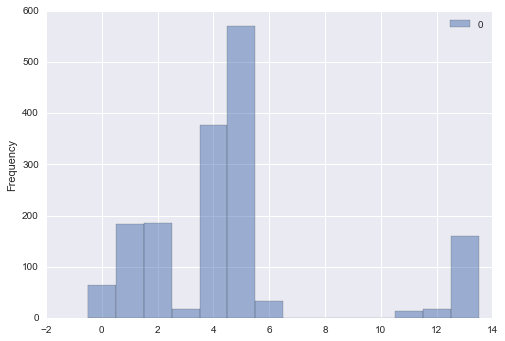

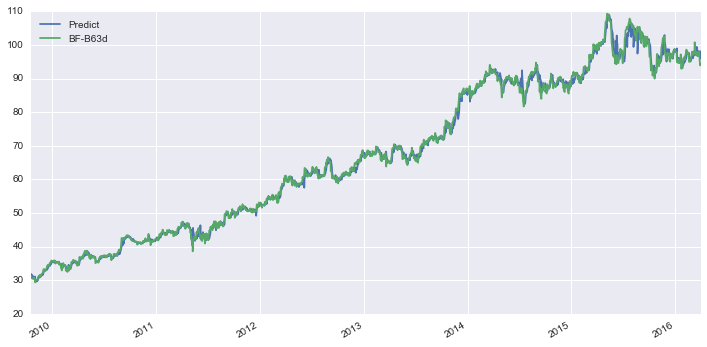

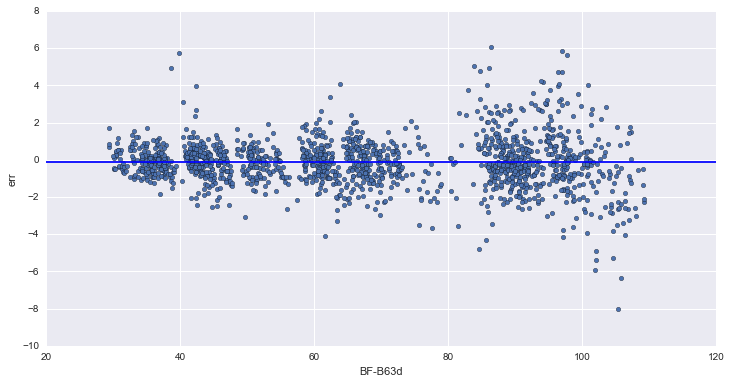

Err mean: -0.131943366682
2 * Std mean: 2.5730619021


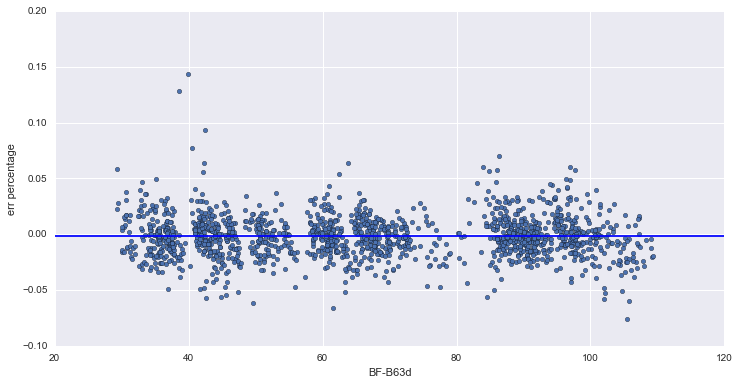

Err percentage mean: -0.00180755960427
2 * Std mean: 0.0367740754151


In [9]:
# Supervised Learning
from sklearn import grid_search
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

def make_predictions(data_X, data_y, date_range, estimator, window=100):
    pred_y_list = []
    feature_importance_list = []
    
    for date in date_range:
        test_X = data_X.ix[date]
        (u,) = data_X.index.get_indexer_for([date])
        
        if u - window < 0:
            raise ValueError("Not enough training data!")
            
        train_X = data_X.iloc[(u - window):u]
        train_y = data_y.iloc[(u - window):u]

        estimator.fit(train_X, train_y)
        pred_y = estimator.predict(test_X.reshape(1, -1))
        pred_y_list.append(pred_y)
        feature_importance_list.append(estimator.feature_importances_)
    
    vif = [int(np.argmax(x)) for x in feature_importance_list]
    vif = pd.DataFrame(vif)
    d = np.diff(np.unique(vif)).min()
    left_of_first_bin = vif.min() - float(d)/2
    right_of_last_bin = vif.max() + float(d)/2
    vif.plot.hist(alpha=0.5, bins=np.arange(left_of_first_bin, right_of_last_bin + d, d))
    return pred_y_list

# lr = LinearRegression()
lr = RandomForestRegressor(criterion='mse', random_state=10, bootstrap=True)
reg = lr
# parameters = {'n_estimators': [10, 100, 1000, 2000], 'max_features': ['sqrt', 'log2', 'auto']}
# parameters = {'n_estimators': [10], 'max_features': ['sqrt', 'log2', 'auto']}
# reg = grid_search.GridSearchCV(lr, parameters, cv=9, scoring='mean_squared_error')

test_y = data_y[100:]
pred_y = pd.Series(make_predictions(data_X, data_y, data_y.index[100:], reg, 100))
pred_y = pd.DataFrame(pred_y.tolist(), index=test_y.index, columns=['Predict'])


# # print("MSE: {}".format(reg.score(test_X, test_y)))
print("R^2: {}".format(r2_score(test_y, pred_y)))
print("MSE: {}".format(mean_squared_error(test_y, pred_y)))

dfResult2 = pred_y.join(test_y, )
dfResult2.columns = ['Predict', label_name]

dfResult2.plot(figsize=(12, 6))
# dfResult2.ix[datetime(2014, 2, 24):datetime(2014, 3, 10)].plot(figsize=(12, 6))

diff2 = (dfResult2['Predict'] - dfResult2[label_name]).to_frame()
diff2 = diff2.join(dfResult2[label_name])
diff2.columns = ['err', label_name]

diff2.plot.scatter(x=label_name, y='err', figsize=(12, 6))
plt.axhline(y=diff2['err'].mean())
plt.show()

print("Err mean: {}".format(diff2['err'].mean()))
print("2 * Std mean: {}".format(2 * diff2['err'].std()))

diff3 = ((dfResult2['Predict'] - dfResult2[label_name]) / dfResult2[label_name]).to_frame()
diff3 = diff3.join(dfResult2[label_name])
diff3.columns = ['err percentage', label_name]

diff3.plot.scatter(x=label_name, y='err percentage', figsize=(12, 6))
plt.axhline(y=diff3['err percentage'].mean())
plt.show()

print("Err percentage mean: {}".format(diff3['err percentage'].mean()))
print("2 * Std mean: {}".format(2 * diff3['err percentage'].std()))

    

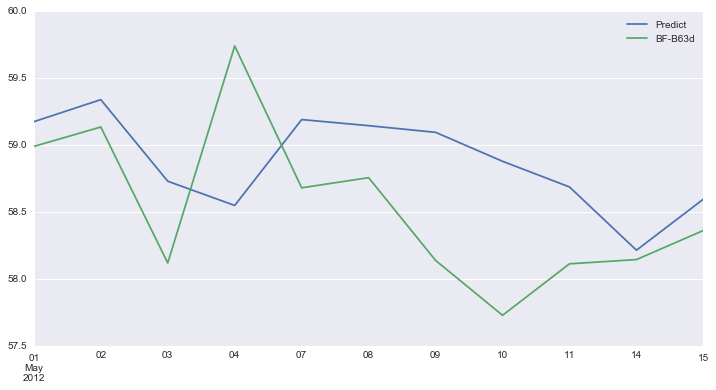

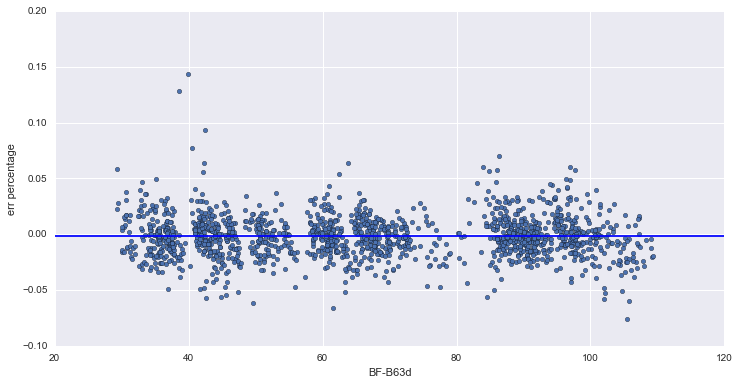

Err percentage mean: -0.00180755960427
2 * Std mean: 0.0367740754151


In [10]:
dfResult2.ix[datetime(2012, 5, 1):datetime(2012, 5, 15)].plot(figsize=(12, 6))

diff3 = ((dfResult2['Predict'] - dfResult2[label_name]) / dfResult2[label_name]).to_frame()
diff3 = diff3.join(dfResult2[label_name])
diff3.columns = ['err percentage', label_name]

diff3.plot.scatter(x=label_name, y='err percentage', figsize=(12, 6))
plt.axhline(y=diff3['err percentage'].mean())
plt.show()

print("Err percentage mean: {}".format(diff3['err percentage'].mean()))
print("2 * Std mean: {}".format(2 * diff3['err percentage'].std()))


### Refinement
#### Grid Search and Cross Validation


In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:

* Has an initial solution been found and clearly reported?
* Is the process of improvement clearly documented, such as what techniques were used?
* Are intermediate and final solutions clearly reported as the process is improved?

## Results
(approximately 2 - 3 pages)

### Model Evaluation and Validation
In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:

* Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?
* Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?
* Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?
* Can results found from the model be trusted?

### Justification
In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:

* Are the final results found stronger than the benchmark result reported earlier?
* Have you thoroughly analyzed and discussed the final solution?
* Is the final solution significant enough to have solved the problem?

## Conclusion
(approximately 1 - 2 pages)

### Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:

* Have you visualized a relevant or important quality about the problem, dataset, input data, or results?
* Is the visualization thoroughly analyzed and discussed?
* If a plot is provided, are the axes, title, and datum clearly defined?

### Reflection
In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:

* Have you thoroughly summarized the entire process you used for this project?
* Were there any interesting aspects of the project?
* Were there any difficult aspects of the project?
* Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?

### Improvement
In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:

* Are there further improvements that could be made on the algorithms or techniques you used in this project?
* Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?
* If you used your final solution as the new benchmark, do you think an even better solution exists?

## Before submitting your report, ask yourself…
* Does the project report you’ve written follow a well-organized structure similar to that of the project template?
* Is each section (particularly Analysis and Methodology) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
* Would the intended audience of your project be able to understand your analysis, methods, and results?
* Have you properly proof-read your project report to assure there are minimal grammatical and spelling mistakes?
* Are all the resources used for this project correctly cited and referenced?
* Is the code that implements your solution easily readable and properly commented?
* Does the code execute without error and produce results similar to those reported?

In [11]:
# from __future__ import division

# # Core
# import numpy as np
# import pandas as pd
# from datetime import date, datetime, timedelta

# # Data Visualization
# %matplotlib inline
# import matplotlib.pyplot as plt
# from IPython.display import display

# # Supervised Learning
# from sklearn import grid_search
# from sklearn.metrics import r2_score
# from sklearn.linear_model import LinearRegression
# from sklearn.svm import SVR
# from sklearn.ensemble import RandomForestRegressor

# # Unsupervised Learning / PCA
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# from sklearn.decomposition import PCA

# # Misc
# from os import getcwd
# import operator
# from math import floor

# # Page Configuration
# pd.set_option('display.max_columns', 200)

# # Define date range
# start_date = '2009-01-01'
# end_date = '2016-06-30'
# date_range = pd.date_range(start_date, end_date)
# df_main = pd.DataFrame(index=date_range)

# # Load SPY to get trading days
# dfSPY = pd.read_csv('stock_data/SPY.csv', index_col='Date', parse_dates=True, usecols=['Date', 'Adj Close'], na_values = ['nan'])
# dfSPY = dfSPY.rename(columns={'Adj Close': 'SPY'})
# # Get SPY within the target date range
# df_main = df_main.join(dfSPY)

# # Drop NaN values
# df_main = df_main.dropna()

# # Load target stocks
# dfSPY500_2009 = pd.read_csv('dev.csv', header=None, usecols = [1])
# symbol = 'GOOGL'

# df_temp = pd.read_csv('stock_data/' + symbol + '.csv', index_col="Date", parse_dates=True, usecols = ['Date', 'Volume', 'Adj Close'], na_values=['nan'])
# df_temp = df_temp.rename(columns={'Volume': symbol + '_Vol', 'Adj Close': symbol})

# ### Forward/Back Fill missing data
# df_main = df_main.join(df_temp, how='left')
# df_main.fillna(method='ffill', inplace=True)
# df_main.fillna(method='bfill', inplace=True)

    
# ###
# ### Feature Engineering Section
# ###
# symbols = ['SPY']
# symbols.append(symbol)

# ### Make Average Run-up Columns (252 days)

# # temp_dict = {}

# # for symbol in symbols:
# #     temp_dict[symbol] = []
    
# #     for i in df_main.index:
# #         (u,) = df_main.index.get_indexer_for([i])
# #         if u - 252 >= 0:
# #             temp_dict[symbol].append((df_main[symbol].iloc[u] - df_main[symbol].iloc[u - 252]) / 252)       
# #         else:
# #             temp_dict[symbol].append(np.nan)
            
# #     df_main[symbol + '_Avg_Runup'] = temp_dict[symbol]

# ### Make Daily Return Columns
# def compute_daily_returns(df, adj_close_name):
#     return (df / df.shift(1) - 1)[adj_close_name]

# for symbol in symbols:
#     df_main[symbol + '_return'] = compute_daily_returns(df_main, symbol)

# ### Make Beta columns (63 days)
# mean_dict = {}
# std_dict = {}

# for symbol in symbols:
#     mean_dict[symbol] = []
#     std_dict[symbol] = []
    
#     for i in df_main.index:
#         (u,) = df_main.index.get_indexer_for([i])
#         if u - 63 >= 0:
#             mean_dict[symbol].append(df_main[symbol + '_return'].iloc[u - 62:u+1].mean())
#             std_dict[symbol].append(df_main[symbol + '_return'].iloc[u - 62:u+1].std())
#         else:
#             mean_dict[symbol].append(np.nan)
#             std_dict[symbol].append(np.nan)
    
#     df_main[symbol + '_Mean63d'] = mean_dict[symbol]
#     df_main[symbol + '_Std63d'] = std_dict[symbol]

# cov_dict = {}

# for symbol in symbols:
#     cov_dict[symbol] = []
#     for i in df_main.index:
#         (u,) = df_main.index.get_indexer_for([i])
#         if u - 62 >= 0:
#             cov_dict[symbol].append(df_main['SPY_return'].iloc[(u - 62):u+1].cov(df_main[symbol + '_return'].iloc[(u - 62):u+1]))
#         else:
#             cov_dict[symbol].append(np.nan)
#     df_main[symbol + '_Cov63d'] = cov_dict[symbol]
#     df_main[symbol + '_Beta'] = df_main[symbol + '_Cov63d'] / df_main[symbol + '_Std63d']**2

# ### Make EMA column (100 days)
# EMA_dict = {}
# alpha = 2 / (100 + 1)

# for symbol in symbols:
#     EMA_dict[symbol] = []
#     EMA_dict[symbol].append(df_main[symbol].iloc[0])
    
#     for i in df_main.index[1:]:
#         (u,) = df_main.index.get_indexer_for([i])
#         EMA_dict[symbol].append(EMA_dict[symbol][u - 1] + alpha * (df_main[symbol].iloc[u] - EMA_dict[symbol][u - 1]))

#     df_main[symbol + '_EMA'] = EMA_dict[symbol]

# ### Make MMA column (100 days)
# MMA_dict = {}
# alpha = 1 / 100

# for symbol in symbols:
#     MMA_dict[symbol] = []
#     MMA_dict[symbol].append(df_main[symbol].iloc[0])
    
#     for i in df_main.index[1:]:
#         (u,) = df_main.index.get_indexer_for([i])
#         MMA_dict[symbol].append(MMA_dict[symbol][u - 1] + alpha * (df_main[symbol].iloc[u] - MMA_dict[symbol][u - 1]))

#     df_main[symbol + '_MMA'] = MMA_dict[symbol]

# ### Make SMA column (100 days)
# for symbol in symbols:
#     df_main[symbol + '_SMA'] = df_main[symbol].rolling(window=101, center=False).mean()

# ### SMA Momentum
# def compute_SMA_momentum(df, SMA_column):
#     return (df - df.shift(1))[SMA_column]*(100 + 1)

# for symbol in symbols:
#     df_main[symbol + '_SMA_Momentum'] = compute_SMA_momentum(df_main, symbol + '_SMA')
    
# ### Volume Momentum
# def compute_Volume_momentum(df, Volume_column):
#     return (df - df.shift(1))[Volume_column]*(100 + 1)

# df_main[symbol + '_Vol_Momentum'] = compute_Volume_momentum(df_main, symbol + '_Vol')

# ### Momentum Real 1
# df_main[symbol + '_p_real1'] = np.nan
# df_main.loc[df_main[symbol + '_Vol_Momentum'] >= 0, symbol + '_p_real1'] = 1
# df_main.loc[df_main[symbol + '_Vol_Momentum'] < 0, symbol + '_p_real1'] = 0

# ### Momentum Real 2
# df_main[symbol + '_p_real2'] = np.nan
# df_main.loc[df_main[symbol + '_Vol'] >= (df_main[symbol + '_Vol'].mean() + df_main[symbol + '_Vol'].std()), symbol + '_p_real2'] = 1
# df_main.loc[df_main[symbol + '_Vol'] < (df_main[symbol + '_Vol'].mean() + df_main[symbol + '_Vol'].std()), symbol + '_p_real2'] = 0

# # # Momentum Real 3
# # df_main[symbol + '_p_real3'] = np.nan
# # df_main.loc[df_main[symbol + '_Vol'] < (df_main[symbol + '_Vol'].mean() - df_main[symbol + '_Vol'].std()), symbol + '_p_real3'] = 0
# # df_main.loc[df_main[symbol + '_Vol'] >= (df_main[symbol + '_Vol'].mean() - df_main[symbol + '_Vol'].std()), symbol + '_p_real3'] = 1

# ### Make SR column
# for symbol in symbols:
#     df_main[symbol + '_SR63d'] = df_main[symbol + '_return'].rolling(window=63, center=False).mean() / df_main[symbol + '_Std63d']

# # Load FSI data
# dfFSI = pd.read_csv('STLFSI.csv', index_col='DATE', parse_dates=True, na_values = ['nan'])
# df_main = df_main.join(dfFSI)
# df_main['STLFSI'].fillna(method='ffill', inplace=True)

# df_main[symbol + '5d'] = df_main.shift(-5)[symbol]
# df_main[symbol + '10d'] = df_main.shift(-10)[symbol]
# df_main[symbol + '15d'] = df_main.shift(-15)[symbol]
# df_main[symbol + '20d'] = df_main.shift(-20)[symbol]
# # print(df_main[['GOOGL_return', 'GOOGL_SMA_Vol']])

# ### Drop not-used columns
# for column in df_main.columns:
#     if 'SPY' in column:
#         df_main.drop([column], axis=1, inplace=True)

# df_main.drop([symbol + '20d', symbol + '10d', symbol + '15d'], axis=1, inplace=True)

# ### Drop NaN rows
# df_main.dropna(inplace=True)

# ### Split Data
# data_X = df_main.drop([symbol + '5d'], axis=1)

# # Normalization
# data_X = (data_X - data_X.mean()) / data_X.std()
# data_y = df_main[symbol + '5d']
# # y_mean = data_y.mean()
# # y_std = data_y.std()
# # data_y = (data_y - y_mean) / y_std

# # Feature Generation
# # poly = PolynomialFeatures(2)
# # data_X2 = poly.fit_transform(data_X)
# # # data_X2 = SelectKBest(chi2, k=2).fit_transform(data_X, data_y)
# # data_X = pd.DataFrame(data_X2, index=data_X.index)

# # data_X.drop([0], axis=1, inplace=True)
# # print(data_X.head())
# # print(data_y)

# train_X = data_X.iloc[:int(floor(data_X.shape[0] * 0.6))]
# train_y = data_y.iloc[:int(floor(data_y.shape[0] * 0.6))]
# test_X = data_X.iloc[int(floor(data_X.shape[0] * 0.6)):]
# test_y = data_y.iloc[int(floor(data_y.shape[0] * 0.6)):]

# # pca = PCA(n_components = 30)
# # pca.fit(data_X)
# # reduced_data = pca.transform(data_X)
# # reduced_data = pd.DataFrame(reduced_data)

# # train_X = reduced_data.iloc[:int(floor(data_X.shape[0] * 0.6))]
# # test_X = reduced_data.iloc[int(floor(data_X.shape[0] * 0.6)):]

# # lr = LinearRegression()
# # parameters = {}
# lr = SVR()
# parameters = {'C': [1, 10, 100, 1000], 'degree': [1, 3, 5, 10], 'kernel': ['linear', 'poly', 'rbf']}

# reg = grid_search.GridSearchCV(lr, parameters, cv=9, scoring='mean_squared_error')

# reg.fit(train_X, train_y)
# pred_y = reg.predict(test_X)
# print(reg.get_params())
# print("MSE: {}".format(reg.score(test_X, test_y)))
# print("R^2: {}".format(r2_score(test_y, pred_y)))

# ### Checking residual plot
# dfResult = pd.DataFrame(reg.predict(test_X), index=test_y.index, columns=['Predict']).join(test_y, )
# dfResult.ix[datetime(2014, 1, 1):datetime(2014, 1, 20)].plot(figsize=(12, 6))
# # dfResult['dummy'] = range(len(dfResult))
# # print(dfResult)
# diff = (dfResult['Predict'] - dfResult[symbol + '5d']).to_frame()
# diff = diff.join(dfResult[symbol + '5d'])
# diff.columns = ['err', symbol + '5d']

# diff.plot.scatter(x=symbol + '5d', y='err', figsize=(12, 6))
# plt.axhline(y=diff['err'].mean())
# plt.show()

# print("Err mean: {}".format(diff['err'].mean()))
# print("2 * Std mean: {}".format(2 * diff['err'].std()))


In [12]:
# from sklearn import cross_validation
# from sklearn.learning_curve import learning_curve
# from data_visualizer.cross_validation import plot_learning_curve

# # Linear Regression Learning Curve
# title = "Learning Curves (LinearRegression)"
# plot_learning_curve(reg, title, train_X, train_y, cv=5, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10))

# plt.show()

In [13]:
# from math import floor

# # Classifiers
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression

# # Regressors
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor

# # Clustering/Dim Reduction
# from sklearn.decomposition import PCA

# # Read in raw dataset
# data = pd.read_csv('first.csv', index_col=0) # raw data

# # Dataset X (feature)
# # data_X = data.drop(['Symbol', 'Date', 'Adj Close', 'RiseOrFall'], axis=1) # drop labels for unsupervised learning
# data_X = data.drop(['Symbol', 'Date', 'Adj Close', 'RiseOrFall', 'open_1d', 'high_1d', 'low_1d', 'volume_1d', 'adjclose_1d', \
#         'open_3d_mean', 'high_3d_mean', 'low_3d_mean', 'volume_3d_mean', 'adjclose_3d_mean', \
#         'open_3d_max', 'high_3d_max', 'low_3d_max', 'volume_3d_max', 'adjclose_3d_max', \
#         'open_3d_min', 'high_3d_min', 'low_3d_min', 'volume_3d_min', 'adjclose_3d_min', \
#         'open_3d_std', 'high_3d_std', 'low_3d_std', 'volume_3d_std', 'adjclose_3d_std', \
#         'open_5d_mean', 'high_5d_mean', 'low_5d_mean', 'volume_5d_mean', 'adjclose_5d_mean', \
#         'open_5d_max', 'high_5d_max', 'low_5d_max', 'adjclose_5d_max', 'volume_5d_max', \
#         'open_5d_min', 'high_5d_min', 'low_5d_min', 'adjclose_5d_min', 'volume_5d_min', \
#         'open_5d_std', 'high_5d_std', 'low_5d_std', 'adjclose_5d_std', 'volume_5d_std'], axis=1) # drop labels for unsupervised learning
# print(data.columns)

# # Normalization
# data_X = (data_X - data_X.mean()) / data_X.std()

# y_mean = data['Adj Close'].mean()
# y_std = data['Adj Close'].std()
# data_y = (data['Adj Close'] - y_mean) / y_std

# train_X = data_X.iloc[:int(floor(data_X.shape[0] * 0.6))]
# train_y = data_y.iloc[:int(floor(data_y.shape[0] * 0.6))]
# test_X = data_X.iloc[int(floor(data_X.shape[0] * 0.6)):]
# test_y = data_y.iloc[int(floor(data.shape[0] * 0.6)):]

# pca = PCA(n_components = 2)
# pca.fit(data_X)
# reduced_data = pca.transform(data_X)
# reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

# # display(reduced_data)
# train_X = reduced_data.iloc[:int(floor(data_X.shape[0] * 0.6))]
# test_X = reduced_data.iloc[int(floor(data_X.shape[0] * 0.6)):]

# # display(train_X.describe())

# reg = LinearRegression()
# reg.fit(train_X, train_y)

# # plt.plot(reg.predict(test_X), data.ix[int(floor(data_X.shape[0] * 0.6)):, 'Date'])
# # plt.show()
# print(reg.score(test_X, test_y))


# label = test_y.reset_index()
# del label['index']

# pred_label = pd.DataFrame(reg.predict(test_X), columns=['Predicted Label'])
# pred_date = data.ix[int(floor(data_X.shape[0] * 0.6)):, 'Date']
# test = pd.Series(pred_date).reset_index().drop(['index'], axis=1)


# result = pd.concat([pred_label, test, label], axis=1, join='inner')

# # print(result)

# result['Date'] = result['Date'].apply(np.datetime64)

# # print(result.describe())

# plt.figure(1, figsize=(40,20))
# plt.axis([np.datetime64('2014-01-01'), np.datetime64('2014-01-10'), 5, 5])
# plt.subplot(211)
# plt.plot(result['Date'], result['Adj Close'])

# plt.subplot(212)
# plt.plot(result['Date'], result['Predicted Label'])

# plt.show()

In [14]:
# from sklearn.cluster import KMeans
# from sklearn.cluster import AffinityPropagation
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.metrics import silhouette_score
# import operator

# scores = {}

# for n in range(2, 11):
#     clusterer = KMeans(n_clusters = n)
#     clusterer.fit(reduced_data)

#     # TODO: Predict the cluster for each data point
#     preds = clusterer.predict(reduced_data)

#     # TODO: Find the cluster centers
#     centers = clusterer.cluster_centers_

#     # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
#     labels = clusterer.labels_
#     score = silhouette_score(reduced_data, labels, metric='euclidean')
#     scores[n] = score
    
#     print "Silhouette score with n = {}: {}".format(n, score)

# max_key = max(scores.keys(), key=(lambda k: scores[k])) 

# clusterer = KMeans(n_clusters = max_key)
# clusterer.fit(reduced_data)

# # TODO: Predict the cluster for each data point
# preds = clusterer.predict(reduced_data)

# # TODO: Find the cluster centers
# centers = clusterer.cluster_centers_

# # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
# labels = clusterer.labels_
# score = silhouette_score(reduced_data, labels, metric='euclidean')
        
# print "Cluster centers: \n{}\n".format(centers)
# print "Silhouette score (max) with n = {}: {}".format(max_key, score)
# centers = clstr.cluster_centers_


In [15]:
# import renders as rs
# rs.cluster_results(reduced_data, preds, centers, centers)

# Capstone Project
## Machine Learning Engineer Nanodegree
**Calvin Ku**

**July 15th, 2016**

## Definition
(approximately 1 - 2 pages)

### Project Overview
In this section, look to provide a high-level overview of the project in layman’s terms. Questions to ask yourself when writing this section:

* Has an overview of the project been provided, such as the problem domain, project origin, and related datasets or input data?
* Has enough background information been given so that an uninformed reader would understand the problem domain and following problem statement?

### Problem Statement

In this section, you will want to clearly define the problem that you are trying to solve, including the strategy (outline of tasks) you will use to achieve the desired solution. You should also thoroughly discuss what the intended solution will be for this problem. Questions to ask yourself when writing this section:

* Is the problem statement clearly defined? Will the reader understand what you are expecting to solve?
* Have you thoroughly discussed how you will attempt to solve the problem?
* Is an anticipated solution clearly defined? Will the reader understand what results you are looking for?

### Metrics
In this section, you will need to clearly define the metrics or calculations you will use to measure performance of a model or result in your project. These calculations and metrics should be justified based on the characteristics of the problem and problem domain. Questions to ask yourself when writing this section:

* Are the metrics you’ve chosen to measure the performance of your models clearly discussed and defined?
* Have you provided reasonable justification for the metrics chosen based on the problem and solution?

## Analysis
(approximately 2 - 4 pages)

### Data Exploration
In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:

* If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?
* If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?
* If a dataset is not present for this problem, has discussion been made about the input space or input data for your problem?
* Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)

### Exploratory Visualization
In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:

* Have you visualized a relevant characteristic or feature about the dataset or input data?
* Is the visualization thoroughly analyzed and discussed?
* If a plot is provided, are the axes, title, and datum clearly defined?

### Algorithms and Techniques
In this section, you will need to discuss the algorithms and techniques you intend to use for solving the problem. You should justify the use of each one based on the characteristics of the problem and the problem domain. Questions to ask yourself when writing this section:

* Are the algorithms you will use, including any default variables/parameters in the project clearly defined?
* Are the techniques to be used thoroughly discussed and justified?
* Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?

### Benchmark
In this section, you will need to provide a clearly defined benchmark result or threshold for comparing across performances obtained by your solution. The reasoning behind the benchmark (in the case where it is not an established result) should be discussed. Questions to ask yourself when writing this section:

* Has some result or value been provided that acts as a benchmark for measuring performance?
* Is it clear how this result or value was obtained (whether by data or by hypothesis)?

## Methodology
(approximately 3 - 5 pages)

### Data Preprocessing
In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:

* If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?
* Based on the Data Exploration section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?
* If no preprocessing is needed, has it been made clear why?

### Implementation
In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:

* Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?
* Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?
* Was there any part of the coding process (e.g., writing complicated functions) that should be documented?

### Refinement
In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:

* Has an initial solution been found and clearly reported?
* Is the process of improvement clearly documented, such as what techniques were used?
* Are intermediate and final solutions clearly reported as the process is improved?

## Results
(approximately 2 - 3 pages)

### Model Evaluation and Validation
In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:

* Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?
* Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?
* Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?
* Can results found from the model be trusted?

### Justification
In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:

* Are the final results found stronger than the benchmark result reported earlier?
* Have you thoroughly analyzed and discussed the final solution?
* Is the final solution significant enough to have solved the problem?

## Conclusion
(approximately 1 - 2 pages)

### Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:

* Have you visualized a relevant or important quality about the problem, dataset, input data, or results?
* Is the visualization thoroughly analyzed and discussed?
* If a plot is provided, are the axes, title, and datum clearly defined?

### Reflection
In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:

* Have you thoroughly summarized the entire process you used for this project?
* Were there any interesting aspects of the project?
* Were there any difficult aspects of the project?
* Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?

### Improvement
In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:

* Are there further improvements that could be made on the algorithms or techniques you used in this project?
* Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?
* If you used your final solution as the new benchmark, do you think an even better solution exists?

## Before submitting your report, ask yourself…
* Does the project report you’ve written follow a well-organized structure similar to that of the project template?
* Is each section (particularly Analysis and Methodology) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
* Would the intended audience of your project be able to understand your analysis, methods, and results?
* Have you properly proof-read your project report to assure there are minimal grammatical and spelling mistakes?
* Are all the resources used for this project correctly cited and referenced?
* Is the code that implements your solution easily readable and properly commented?
* Does the code execute without error and produce results similar to those reported?